# Alteration of intercellular signaling in ulcerative colitis

Analysising single cell RNA-seq data for inter and intracellular interactions. 
The first step is to import the singel cell RNA-seq data file. The import file is the cell cluster averaged gene expression files. OmniPath is accesed by the python client.

In [2]:
import pandas as pd
import igraph as ig
import os
from itertools import permutations
import numpy as np

In [3]:
import omnipath as op

First lets check the OmniPAth version and data.

In [4]:
print(op.__server_version__)
print(op.options)

0.16.4
Options(url='https://omnipathdb.org', fallback_urls=('http://no-tls.omnipathdb.org',), static_url='http://no-tls.static.omnipathdb.org/resources', license=None, cache=<FileCache[size=0, path='/Users/maya/.cache/omnipathdb']>, autoload=True, convert_dtypes=True, num_retries=3, timeout=600, chunk_size=8196)


Now we can donwload OmniPath intercellular network and see what kind of columns are in the intercellular dataframe. 

In [4]:
intercell_network = op.interactions.import_intercell_network()

In [5]:
intercell_network.head()

,index,source,target,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,dip_url,curation_effort,...,category_source_intercell_target,uniprot_intercell_target,genesymbol_intercell_target,entity_type_intercell_target,consensus_score_intercell_target,transmitter_intercell_target,receiver_intercell_target,secreted_intercell_target,plasma_membrane_transmembrane_intercell_target,plasma_membrane_peripheral_intercell_target
0,0,P14416,P48995,True,False,True,True,False,nan,1,...,resource_specific,P48995,TRPC1,protein,1,False,True,False,False,False
1,2,P14416,P48995,True,False,True,True,False,nan,1,...,resource_specific,P48995,TRPC1,protein,3,False,True,False,False,False
2,5,P14416,P48995,True,False,True,True,False,nan,1,...,composite,P48995,TRPC1,protein,3,False,True,False,False,False
3,7,Q13255,P48995,True,False,True,True,False,nan,1,...,resource_specific,P48995,TRPC1,protein,1,False,True,False,False,False
4,9,Q13255,P48995,True,False,True,True,False,nan,1,...,resource_specific,P48995,TRPC1,protein,3,False,True,False,False,False


In [6]:
intercell_network.columns

Index(['index', 'source', 'target', 'is_stimulation', 'is_inhibition',
       'consensus_direction', 'consensus_stimulation', 'consensus_inhibition',
       'dip_url', 'curation_effort', 'references', 'sources',
       'references_stripped', 'n_references', 'n_sources', 'n_primary_sources',
       'category_intercell_source', 'parent_intercell_source',
       'database_intercell_source', 'scope_intercell_source',
       'aspect_intercell_source', 'category_source_intercell_source',
       'uniprot_intercell_source', 'genesymbol_intercell_source',
       'entity_type_intercell_source', 'consensus_score_intercell_source',
       'transmitter_intercell_source', 'receiver_intercell_source',
       'secreted_intercell_source',
       'plasma_membrane_transmembrane_intercell_source',
       'plasma_membrane_peripheral_intercell_source',
       'category_intercell_target', 'parent_intercell_target',
       'database_intercell_target', 'scope_intercell_target',
       'aspect_intercell_target'

In [7]:
intercell_network.shape

(30265, 46)

Here we can check what are the categories what we can use for intercellular interactions. We can use the intercellular interctions directly, hovewer it contain porteins which are invovled in the adhesion process and binds to the intracelluar domains of receptor proteins. That is why we suggest the fitlering as in the paper.  

In [8]:
print (set(intercell_network["category_intercell_source"]))

{'desmosome', 'cell_surface_ligand', 'cell_surface_enzyme', 'secreted_receptor', 'ecm', 'receptor_regulator', 'adhesion', 'tight_junction', 'cell_adhesion', 'matrix_adhesion_regulator', 'cell_surface_peptidase', 'ecm_regulator', 'secreted_enzyme', 'ligand_regulator', 'gap_junction', 'ligand'}


In [9]:
print (set(intercell_network["category_intercell_target"]))

{'adherens_junction', 'receptor', 'ion_channel_regulator', 'desmosome', 'adhesion', 'tight_junction', 'cell_adhesion', 'matrix_adhesion', 'transporter', 'ion_channel', 'gap_junction'}


In [10]:
filtered_source_types = ["cell_surface_enzyme","cell_surface_ligand","ligand","secreted_enzyme","secreted_receptor",
           "adhesion","cell_adhesion","tight_junction","cell_surface_peptidase","gap_junction","desmosome"]
filtered_target_types = ["adhesion","receptor","cell_adhesion","tight_junction","gap_junction","ion_channel","transporter",
                "adherens_junction"]

In [11]:
filtered_intercell_network = intercell_network[intercell_network.category_intercell_source.isin(filtered_source_types)] 
filtered_intercell_network = filtered_intercell_network[filtered_intercell_network.
                                                        category_intercell_target.isin(filtered_target_types)]
filtered_intercell_network.shape

(20784, 46)

The next step is to preprocess the data files. The imput file is the cell type specfic expression. The data are from Smillie et al 2019 (https://pubmed.ncbi.nlm.nih.gov/31348891/). Each column is the average per cell type in transcript per million. From that we will build a simple cell-cell interaction count. It is based on expression tresholding. Our assumptation was that the interactions are important if they are exisit in any way, so we have chosen a realtievely low expression treshold. We invite the user for testing various tresholds in their own work. 
You will need for this the expression data which are in this example's folder.

In [12]:
df_cell_imm = pd.read_csv("imm_all_expression_condition.tsv", sep="\t", index_col=0, header=0)
df_cell_fib = pd.read_csv("fib_all_expression_condition.tsv",sep="\t", index_col=0, header=0)
df_cell_epi =  pd.read_csv("epi_all_expression_condition.tsv",sep="\t", index_col=0, header=0)
df_cell_exp = df_cell_imm.join(df_cell_fib, how="outer") #Keeping all genes
df_cell_exp = df_cell_exp.join(df_cell_epi, how="outer")

In [13]:
df_cell_exp.head()

,RNA.CD8..IELs_Healthy,RNA.CD8..LP_Healthy,RNA.CD4..Memory_Healthy,RNA.MT.hi_Healthy,RNA.Cycling.T_Healthy,RNA.NKs_Healthy,RNA.CD4..Activated.Fos.lo_Healthy,RNA.CD4..Activated.Fos.hi_Healthy,RNA.CD8..IELs_Uninflamed,RNA.MT.hi_Uninflamed,...,RNA.Immature.Goblet_Inflamed,RNA.Stem_Uninflamed,RNA.Immature.Enterocytes.2_Inflamed,RNA.Goblet_Inflamed,RNA.Tuft_Inflamed,RNA.Enterocytes_Inflamed,RNA.Best4..Enterocytes_Inflamed,RNA.Enteroendocrine_Inflamed,RNA.M.cells_Inflamed,RNA.M.cells_Uninflamed
7SK,0.030182,0.042158,0.016792,0.000000,0.000000,0.228991,0.000000,0.015092,0.030573,0.000000,...,0.00000,0.001679,0.000000,0.000000,7.005192,0.002465,0.007913,0.000000,0.000000,0.000000
A1BG,0.062424,0.025848,0.049498,0.208431,0.321939,0.000000,0.045158,0.018531,0.053037,0.000000,...,0.00000,0.013224,0.002473,0.089265,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A1BG-AS1,0.276995,0.198592,0.138406,0.295042,0.000000,0.498747,0.130186,0.256156,0.305482,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1CF,0.002978,0.005669,0.000000,0.000000,0.025840,0.000000,0.000000,0.000000,0.079150,0.000000,...,0.66123,0.211192,0.848589,0.187466,0.000000,0.486224,0.778587,2.653654,0.457293,0.737544
A2M,0.023545,0.214442,0.202609,0.167921,0.097767,0.545677,0.144894,0.166956,0.010304,0.243075,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


We will choose the mean -2SD of the whole data set. First we do a log2 based transformation.

In [14]:
df_cell_exp[df_cell_exp.values == 0] = "NaN"

In [15]:
df_cell_exp.head()

,RNA.CD8..IELs_Healthy,RNA.CD8..LP_Healthy,RNA.CD4..Memory_Healthy,RNA.MT.hi_Healthy,RNA.Cycling.T_Healthy,RNA.NKs_Healthy,RNA.CD4..Activated.Fos.lo_Healthy,RNA.CD4..Activated.Fos.hi_Healthy,RNA.CD8..IELs_Uninflamed,RNA.MT.hi_Uninflamed,...,RNA.Immature.Goblet_Inflamed,RNA.Stem_Uninflamed,RNA.Immature.Enterocytes.2_Inflamed,RNA.Goblet_Inflamed,RNA.Tuft_Inflamed,RNA.Enterocytes_Inflamed,RNA.Best4..Enterocytes_Inflamed,RNA.Enteroendocrine_Inflamed,RNA.M.cells_Inflamed,RNA.M.cells_Uninflamed
7SK,0.0301819,0.0421578,0.0167924,NaN,NaN,0.228991,NaN,0.0150918,0.0305725,NaN,...,NaN,0.00167886,NaN,NaN,7.00519,0.00246488,0.00791332,NaN,NaN,NaN
A1BG,0.062424,0.0258481,0.0494975,0.208431,0.321939,NaN,0.0451578,0.0185314,0.0530365,NaN,...,NaN,0.0132239,0.0024732,0.089265,NaN,NaN,NaN,NaN,NaN,NaN
A1BG-AS1,0.276995,0.198592,0.138406,0.295042,NaN,0.498747,0.130186,0.256156,0.305482,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1CF,0.00297762,0.00566872,NaN,NaN,0.0258403,NaN,NaN,NaN,0.0791505,NaN,...,0.66123,0.211192,0.848589,0.187466,NaN,0.486224,0.778587,2.65365,0.457293,0.737544
A2M,0.0235452,0.214442,0.202609,0.167921,0.0977667,0.545677,0.144894,0.166956,0.0103037,0.243075,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
data_matrix = df_cell_exp.to_numpy()
data_matrix_log2 = np.log2(data_matrix.astype(float)) #We need to change the data file to floats
mean_cell = np.nanmean(data_matrix_log2)
std = np.nanstd(data_matrix_log2)

In [17]:
mean_cell, std

(-2.160708171397226, 3.00937762482671)

In [18]:
import seaborn as sns

We can check the distribuiton of the cell types. Here only for one.

In [19]:
data_matrix_log2

array([[-5.0501723 , -4.56805614, -5.89604351, ...,         nan,
                nan,         nan],
       [-4.00175632, -5.27379813, -4.33649916, ...,         nan,
                nan,         nan],
       [-1.85206773, -2.33211901, -2.8530207 , ...,         nan,
                nan,         nan],
       ...,
       [-3.47290816, -4.19215007, -4.40580567, ..., -2.06536459,
         0.35303725,  0.44592408],
       [-4.38586399, -2.27399124, -3.85313444, ..., -4.58601467,
        -8.31527547,         nan],
       [-2.5735855 , -1.76640068, -1.1066736 , ..., -4.14328163,
        -7.335609  ,         nan]])

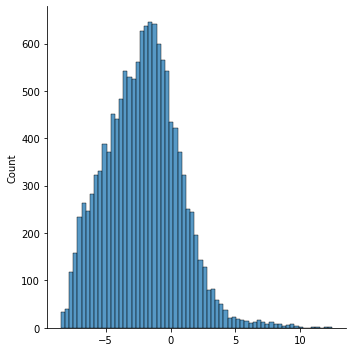

In [20]:
sns.displot(data_matrix_log2[:,0])

After checking the histogram we can say that we will use the mean minus 2 standard deviation of the expressed genes.

In [21]:
data_matrix_log2 > (mean_cell-2*std)

C:\Users\modos\.conda\envs\Single_cell_RNA_seq\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True, False, False],
       [ True,  True,  True, ...,  True,  True, False]])

For simplicity we call "NaN" each number which is below the treshold.

In [22]:
df_cell_log2 = pd.DataFrame(data=data_matrix_log2, index=df_cell_exp.index ,columns=df_cell_exp.columns)

In [23]:
df_cell_log2.head()

,RNA.CD8..IELs_Healthy,RNA.CD8..LP_Healthy,RNA.CD4..Memory_Healthy,RNA.MT.hi_Healthy,RNA.Cycling.T_Healthy,RNA.NKs_Healthy,RNA.CD4..Activated.Fos.lo_Healthy,RNA.CD4..Activated.Fos.hi_Healthy,RNA.CD8..IELs_Uninflamed,RNA.MT.hi_Uninflamed,...,RNA.Immature.Goblet_Inflamed,RNA.Stem_Uninflamed,RNA.Immature.Enterocytes.2_Inflamed,RNA.Goblet_Inflamed,RNA.Tuft_Inflamed,RNA.Enterocytes_Inflamed,RNA.Best4..Enterocytes_Inflamed,RNA.Enteroendocrine_Inflamed,RNA.M.cells_Inflamed,RNA.M.cells_Uninflamed
7SK,-5.050172,-4.568056,-5.896044,NaN,NaN,-2.126639,NaN,-6.050093,-5.031619,NaN,...,NaN,-9.218304,NaN,NaN,2.808425,-8.664267,-6.981502,NaN,NaN,NaN
A1BG,-4.001756,-5.273798,-4.336499,-2.262358,-1.635142,NaN,-4.468881,-5.753884,-4.236870,NaN,...,NaN,-6.240706,-8.659406,-3.485761,NaN,NaN,NaN,NaN,NaN,NaN
A1BG-AS1,-1.852068,-2.332119,-2.853021,-1.761008,NaN,-1.003621,-2.941349,-1.964903,-1.710843,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1CF,-8.391626,-7.462761,NaN,NaN,-5.274231,NaN,NaN,NaN,-3.659258,NaN,...,-0.596775,-2.243375,-0.236862,-2.415296,NaN,-1.040307,-0.361069,1.40798,-1.12881,-0.4392
A2M,-5.408426,-2.221338,-2.303227,-2.574148,-3.354513,-0.873881,-2.786930,-2.582460,-6.600697,-2.040528,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We will call every genee which is expressed below the treshold with "NaN".

In [24]:
df_cell_log2[df_cell_log2.values < (mean_cell-2*std)] = "NaN"

C:\Users\modos\.conda\envs\Single_cell_RNA_seq\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


Let's see what we hjave done and the avaialbe cell types.

In [25]:
df_cell_log2.head()

,RNA.CD8..IELs_Healthy,RNA.CD8..LP_Healthy,RNA.CD4..Memory_Healthy,RNA.MT.hi_Healthy,RNA.Cycling.T_Healthy,RNA.NKs_Healthy,RNA.CD4..Activated.Fos.lo_Healthy,RNA.CD4..Activated.Fos.hi_Healthy,RNA.CD8..IELs_Uninflamed,RNA.MT.hi_Uninflamed,...,RNA.Immature.Goblet_Inflamed,RNA.Stem_Uninflamed,RNA.Immature.Enterocytes.2_Inflamed,RNA.Goblet_Inflamed,RNA.Tuft_Inflamed,RNA.Enterocytes_Inflamed,RNA.Best4..Enterocytes_Inflamed,RNA.Enteroendocrine_Inflamed,RNA.M.cells_Inflamed,RNA.M.cells_Uninflamed
7SK,-5.05017,-4.56806,-5.896044,NaN,NaN,-2.126639,NaN,-6.05009,-5.031619,NaN,...,NaN,NaN,NaN,NaN,2.808425,NaN,-6.9815,NaN,NaN,NaN
A1BG,-4.00176,-5.2738,-4.336499,-2.262358,-1.635142,NaN,-4.46888,-5.75388,-4.236870,NaN,...,NaN,-6.24071,NaN,-3.48576,NaN,NaN,NaN,NaN,NaN,NaN
A1BG-AS1,-1.85207,-2.33212,-2.853021,-1.761008,NaN,-1.003621,-2.94135,-1.9649,-1.710843,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1CF,NaN,-7.46276,NaN,NaN,-5.274231,NaN,NaN,NaN,-3.659258,NaN,...,-0.596775,-2.24338,-0.236862,-2.4153,NaN,-1.04031,-0.361069,1.40798,-1.12881,-0.4392
A2M,-5.40843,-2.22134,-2.303227,-2.574148,-3.354513,-0.873881,-2.78693,-2.58246,-6.600697,-2.040528,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
print(set(df_cell_log2.columns))

{'RNA.Macrophages_Uninflamed', 'RNA.CD4..PD1._Inflamed', 'RNA.ILCs_Inflamed', 'RNA.Cycling.TA_Healthy', 'RNA.TA.1_Inflamed', 'RNA.WNT2B..Fos.lo.1_Uninflamed', 'RNA.Tregs_Healthy', 'RNA.Best4..Enterocytes_Inflamed', 'RNA.Enterocyte.Progenitors_Inflamed', 'RNA.Microvascular_Inflamed', 'RNA.Goblet_Inflamed', 'RNA.CD4..Activated.Fos.hi_Healthy', 'RNA.CD8..IELs_Inflamed', 'RNA.WNT5B..2_Uninflamed', 'RNA.Inflammatory.Fibroblasts_Inflamed', 'RNA.CD8..IELs_Healthy', 'RNA.DC2_Inflamed', 'RNA.Tregs_Uninflamed', 'RNA.Immature.Enterocytes.1_Inflamed', 'RNA.WNT5B..2_Healthy', 'RNA.Follicular_Uninflamed', 'RNA.Inflammatory.Monocytes_Uninflamed', 'RNA.Microvascular_Uninflamed', 'RNA.Plasma_Uninflamed', 'RNA.CD8..IL17._Inflamed', 'RNA.CD8..IELs_Uninflamed', 'RNA.DC1_Inflamed', 'RNA.M.cells_Uninflamed', 'RNA.WNT5B..1_Inflamed', 'RNA.WNT2B..Fos.lo.2_Uninflamed', 'RNA.CD4..Activated.Fos.lo_Uninflamed', 'RNA.Cycling.Monocytes_Inflamed', 'RNA.NKs_Healthy', 'RNA.Secretory.TA_Inflamed', 'RNA.GC_Healthy', 'RN

Next we select healthy/uninflamed average expression data in the 5 selected cell types.

In [27]:
df_macrophage_healthy = df_cell_log2['RNA.Macrophages_Healthy']
df_macrophage_uninflamed = df_cell_log2['RNA.Macrophages_Uninflamed']

df_DC1_healthy = df_cell_log2['RNA.DC1_Healthy']
df_DC1_uninflamed = df_cell_log2['RNA.DC1_Uninflamed']

df_Treg_healthy = df_cell_log2['RNA.Tregs_Healthy']
df_Treg_uninflamed = df_cell_log2['RNA.Tregs_Uninflamed'] 

df_myofibroblast_healthy = df_cell_log2['RNA.Myofibroblasts_Healthy']
df_myofibroblast_uninflamed = df_cell_log2['RNA.Myofibroblasts_Uninflamed']

df_goblet_healthy = df_cell_log2['RNA.Goblet_Healthy']
df_goblet_uninflamed = df_cell_log2['RNA.Goblet_Uninflamed']


For calcualting the intercellular interactions we can store theese dataframes in a dictionarry.

In [28]:
healthy_cell_types = {"DC1": df_DC1_healthy,"Macrophage": df_macrophage_healthy, "Goblet": df_goblet_healthy,
                      "Myofibroblast": df_myofibroblast_healthy, 'Treg': df_Treg_healthy}

uninflamed_cell_types = {"DC1": df_DC1_uninflamed,"Macrophage": df_macrophage_uninflamed, "Goblet": df_goblet_uninflamed,
                         "Myofibroblast": df_myofibroblast_uninflamed, 'Treg': df_Treg_uninflamed} 

Next we can use the intercellular interactions.

In [29]:
# create dictionaries for source-target interactions and their annotations from OmniPath
interactions = {}
interaction_annotation = {}

for i, interaction in filtered_intercell_network.iterrows():
    if interaction["genesymbol_intercell_source"] not in interactions:
        interactions[interaction["genesymbol_intercell_source"]] = []
    if interaction["genesymbol_intercell_target"] not in  interactions[interaction["genesymbol_intercell_source"]]:
        interactions[interaction["genesymbol_intercell_source"]].append(interaction["genesymbol_intercell_target"])
    source_tupple = (interaction["genesymbol_intercell_source"],interaction["category_intercell_source"])
    target_tupple = (interaction["genesymbol_intercell_target"],interaction["category_intercell_target"])
    if source_tupple not in interaction_annotation:
        interaction_annotation[source_tupple] = []
    if target_tupple not in interaction_annotation[source_tupple]:
        interaction_annotation[source_tupple].append(target_tupple)

Create all of the possible interactions of cells (independently from the condition)
Important: directionality (A-B and B-A are different)

In [30]:
def create_interactions(cells, healthy_cell_types,interactions):
    healthy_interactions = set()
    for source in healthy_cell_types[cells[0]].keys():
            # selecting those ones which play role in intercellular communication as a transmitter
            if source in interactions.keys():
                # iterating through target cell type expressed genes
                for target in healthy_cell_types[cells[1]].keys():

                    # selecting those ones which play role in intercellular communication as a receiver
                    if target in interactions[source]:
                        if str(healthy_cell_types[cells[1]][target]) != 'nan' and str(healthy_cell_types[cells[0]][source]) != 'nan':
                            healthy_interactions.add((source, target))
    return healthy_interactions
    

In [31]:
#Creating dictinaries dataframe for healthy and UC interactions
healthy_intercell_tupplellist = []
uc_intercell_tupplelist = []

In [32]:
for i in healthy_cell_types.keys():
    for j in healthy_cell_types.keys():
        if i!=j:
            print(i,j)
            # storing cell-type specific connections in sets
            healthy_interactions = create_interactions([i,j], healthy_cell_types, interactions)
            UC_interactions = create_interactions([i,j], uninflamed_cell_types,interactions)
            # writing out the condition specific interactions
            healthy_only = healthy_interactions.difference(UC_interactions)
            UC_only = UC_interactions.difference(healthy_interactions)
            #Adding the intercellular interactions
            healthy_intercell_tupplellist.append((i,j,len(healthy_only)))
            uc_intercell_tupplelist.append((i,j,len(UC_only)))

            with open(i + "_" + j + "_healthy_only.txt", 'w') as output_file_1:
                #print(UC_only)
                for inter in healthy_only:
                    for source_annotation in interaction_annotation:
                        if inter[0] == source_annotation[0]:
                            for target_annotation in interaction_annotation[source_annotation]:
                                if inter[1] == target_annotation[0]:
                                    output_file_1.write(source_annotation[0] + "," + source_annotation[1] + "," 
                                                        + target_annotation[0] + "," + target_annotation[1] + "\n")
            with open(i + "_" + j + "_UC_only.txt", 'w') as output_file_2:
                for inter in UC_only:
                        for source_annotation in interaction_annotation:
                            if inter[0] == source_annotation[0]:
                                for target_annotation in interaction_annotation[source_annotation]:
                                    if inter[1] == target_annotation[0]:
                                        output_file_2.write(source_annotation[0] + "," + source_annotation[1] + ","
                                                            + target_annotation[0] + "," + target_annotation[1] + "\n")

DC1 Macrophage
DC1 Goblet
DC1 Myofibroblast
DC1 Treg
Macrophage DC1
Macrophage Goblet
Macrophage Myofibroblast
Macrophage Treg
Goblet DC1
Goblet Macrophage
Goblet Myofibroblast
Goblet Treg
Myofibroblast DC1
Myofibroblast Macrophage
Myofibroblast Goblet
Myofibroblast Treg
Treg DC1
Treg Macrophage
Treg Goblet
Treg Myofibroblast


Next we make the graphs of the interactions between the cells.

In [33]:
g_healthy = ig.Graph.TupleList(healthy_intercell_tupplellist, weights=True, directed=True)
g_uc = ig.Graph.TupleList(uc_intercell_tupplelist, weights=True, directed=True)

In [34]:
healthy_intercell_tupplellist

[('DC1', 'Macrophage', 912),
 ('DC1', 'Goblet', 781),
 ('DC1', 'Myofibroblast', 731),
 ('DC1', 'Treg', 557),
 ('Macrophage', 'DC1', 568),
 ('Macrophage', 'Goblet', 689),
 ('Macrophage', 'Myofibroblast', 617),
 ('Macrophage', 'Treg', 501),
 ('Goblet', 'DC1', 457),
 ('Goblet', 'Macrophage', 652),
 ('Goblet', 'Myofibroblast', 483),
 ('Goblet', 'Treg', 438),
 ('Myofibroblast', 'DC1', 437),
 ('Myofibroblast', 'Macrophage', 558),
 ('Myofibroblast', 'Goblet', 483),
 ('Myofibroblast', 'Treg', 387),
 ('Treg', 'DC1', 491),
 ('Treg', 'Macrophage', 800),
 ('Treg', 'Goblet', 682),
 ('Treg', 'Myofibroblast', 616)]

Now we can visualise the interactions.
Igraph contain the visulasitation parameters as a dictionarry. You can also wirte out the edgelist to visualise it in cytoscape.

In [35]:
g_healthy.es

In [36]:
visual_style = {}

Below are the iGraph visual parameters which you can play with for your intercellular network.

In [37]:
# Curve the edges
visual_style["edge_curved"] = True
# Set the layout
my_layout = g_healthy.layout_circle(order=["Goblet","Treg","Myofibroblast","Macrophage","DC1"])
visual_style["layout"] = my_layout
#Add annoation
visual_style["vertex_label"] = g_healthy.vs["name"]
#Calcualte the edge wheight relative the number of edges
visual_style["edge_width"] = 0.01 * np.array(g_healthy.es["weight"])

#Setting the vertex visualistation parameters -colours and label position
visual_style["vertex_label_size"] = 30
visual_style["vertex_color"] = "grey"
visual_style["vertex_label_dist"] = 0.75
visual_style["vertex_size"] = 40

#Setting the edge visualisation parameters
visual_style["edge_color"] = "#004C66" #hexa code for blue
visual_style["edge_arrow_size"] = 2

#Setting the visualistation place. igraph need margin yo work
visual_style["bbox"] = (600, 600)
visual_style["margin"] = 100

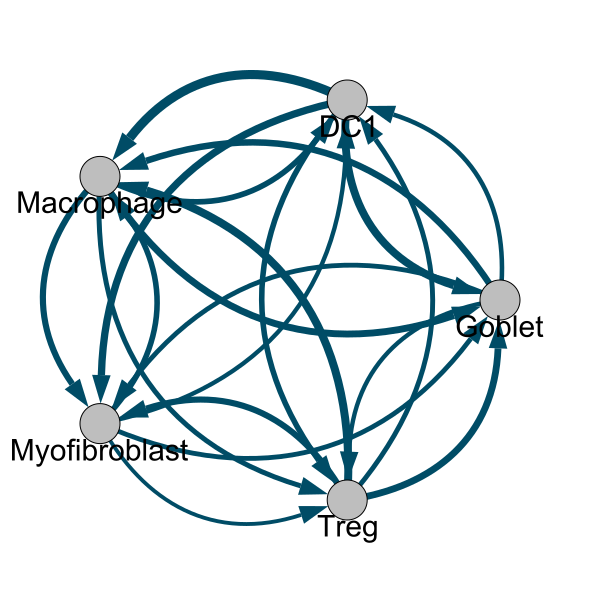

In [38]:
ig.plot(g_healthy, "healthy.png", **visual_style)

Now we can do the same for the uninflmaed UC cells.

In [39]:
# Curve the edges
visual_style["edge_curved"] = True
# Set the layout - we keep the same layout for comapriosn
visual_style["layout"] = my_layout
#Add annoation
visual_style["vertex_label"] = g_uc.vs["name"]
#Calcualte the edge wheight relative the number of edges
visual_style["edge_width"] = 0.01 * np.array(g_uc.es["weight"])

#Setting the vertex visualistation parameters -colours and label position
visual_style["vertex_label_size"] = 30
visual_style["vertex_color"] = "grey"
visual_style["vertex_label_dist"] = 0.75
visual_style["vertex_size"] = 40

#Setting the edge visualisation parameters
visual_style["edge_color"] = "#CE1612" #hexa code for red
visual_style["edge_arrow_size"] = 2

#Setting the visualistation place. igraph need margin yo work
visual_style["bbox"] = (600, 600)
visual_style["margin"] = 100

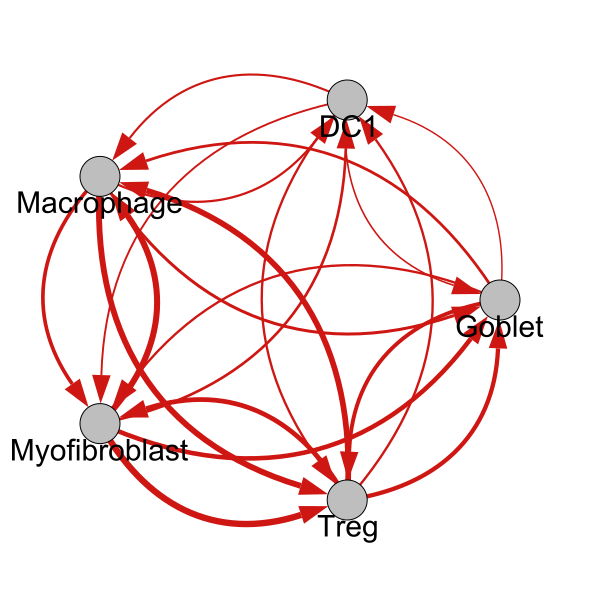

In [40]:
ig.plot(g_uc, "UC_uninflamed.png", **visual_style)

Below you can see what kind of data we have used.

In [41]:
import types
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__
list(imports())

['builtins',
 'builtins',
 'pandas',
 'igraph',
 'os',
 'numpy',
 'omnipath',
 'seaborn',
 'types']

In [42]:
print('\n'.join(f'{m.__name__} {m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

pandas 1.1.4
igraph 0.8.3
numpy 1.18.5
omnipath 1.0.0
seaborn 0.11.0
